# Benchmarking GeoPackage and Parquet
 
Writing large geopackages can take forever with GeoPandas. How much does Parquet / pyogrio speed things up?

Jonathan Markel  
3D Geospatial Laboratory  
The University of Texas at Austin  
08/30/2023

##### [Twitter](https://twitter.com/jonm3d) | [GitHub](https://github.com/jonm3d) | [Website](http://j3d.space) | [GoogleScholar](https://scholar.google.com/citations?user=KwxwFgYAAAAJ&hl=en) | [LinkedIn](https://www.linkedin.com/in/j-markel/) 

In [2]:
pip install pyogrio

Note: you may need to restart the kernel to use updated packages.


In [11]:
import geopandas as gpd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import timeit
from matplotlib.ticker import MaxNLocator

path_to_file = "/home/jovyan/geobench/data/larger.gpkg"
bench_dir = "/home/jovyan/geobench/outputs"

df = gpd.read_file(path_to_file, engine="pyogrio")

def write_to_parquet():
    df.to_parquet(os.path.join(bench_dir, 'test.parquet'))

def read_from_parquet():
    gpd.read_parquet(os.path.join(bench_dir, 'test.parquet'))

def write_with_pyogrio():
    df.to_file(os.path.join(bench_dir, 'test.gpkg'), driver='GPKG', engine="pyogrio")
    
def write_without_pyogrio():
    df.to_file(os.path.join(bench_dir, 'test.gpkg'), driver='GPKG')

def read_with_pyogrio():
    gpd.read_file(os.path.join(bench_dir, 'test.gpkg'), engine="pyogrio")

def read_without_pyogrio():
    gpd.read_file(os.path.join(bench_dir, 'test.gpkg'))

number_of_repeats = 5

print('Benchmarking parquet write...')
parquet_write_time = timeit.timeit(write_to_parquet, number=number_of_repeats) / number_of_repeats
print('Benchmarking parquet read...')
parquet_read_time = timeit.timeit(read_from_parquet, number=number_of_repeats) / number_of_repeats

print('Benchmarking GeoPackage write with pyogrio...')
gpkg_write_time_pyogrio = timeit.timeit(write_with_pyogrio, number=number_of_repeats) / number_of_repeats
print('Benchmarking GeoPackage read with pyogrio...')
gpkg_read_time_pyogrio = timeit.timeit(read_with_pyogrio, number=number_of_repeats) / number_of_repeats

print('Benchmarking GeoPackage write without pyogrio...')
gpkg_write_time_without_pyogrio = timeit.timeit(write_without_pyogrio, number=number_of_repeats) / number_of_repeats
print('Benchmarking GeoPackage read without pyogrio...')
gpkg_read_time_without_pyogrio = timeit.timeit(read_without_pyogrio, number=number_of_repeats) / number_of_repeats

Benchmarking parquet write...
Benchmarking parquet read...
Benchmarking GeoPackage write with pyogrio...
Benchmarking GeoPackage read with pyogrio...
Benchmarking GeoPackage write without pyogrio...
Benchmarking GeoPackage read without pyogrio...


In [12]:
# Storing results in a dataframe for writing
write_results = {
    'Format': ['parquet', 'gpkg (pyogrio)', 'gpkg'],
    'Average Write Time (s)': [parquet_write_time, gpkg_write_time_pyogrio, gpkg_write_time_without_pyogrio]
}
write_df = pd.DataFrame(write_results)

# Storing results in a dataframe for reading
read_results = {
    'Format': ['parquet', 'gpkg (pyogrio)', 'gpkg'],
    'Average Read Time (s)': [parquet_read_time, gpkg_read_time_pyogrio, gpkg_read_time_without_pyogrio]
}
read_df = pd.DataFrame(read_results)

# Combine the write and read dataframes for easy plotting
combined_df = write_df.merge(read_df, on='Format')
melted_df = combined_df.melt(id_vars=['Format'], value_vars=['Average Write Time (s)', 'Average Read Time (s)'])

# Simplify the variable names for the hue labels
melted_df['variable'] = melted_df['variable'].replace({
    'Average Write Time (s)': 'Write',
    'Average Read Time (s)': 'Read'
})

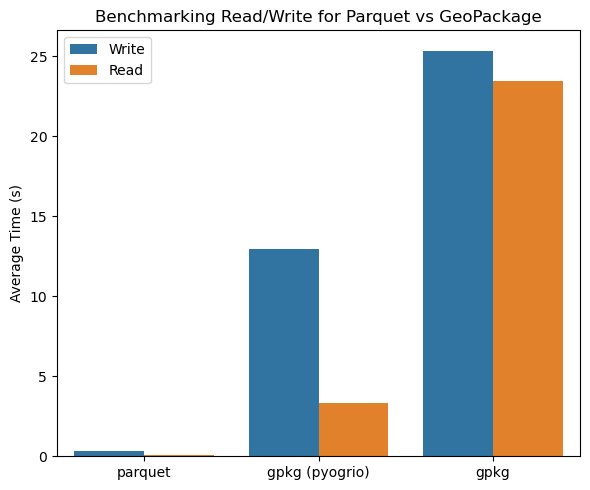

<Figure size 640x480 with 0 Axes>

In [13]:
# Display the results
plt.figure(figsize=(6, 5))
sns.barplot(x='Format', y='value', hue='variable', data=melted_df)
plt.xlabel('')
plt.ylabel('Average Time (s)')
plt.title('Benchmarking Read/Write for Parquet vs GeoPackage')
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(bench_dir, 'speed_results.png'))

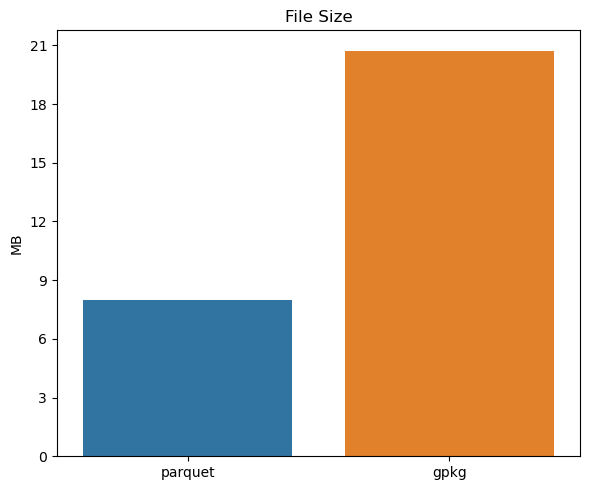

<Figure size 640x480 with 0 Axes>

In [14]:
# Get the file sizes
def get_file_size(file_path):
    return os.path.getsize(file_path) / 1024 / 1024  # Convert to MB

parquet_file_size = get_file_size(os.path.join(bench_dir, 'test.parquet'))
gpkg_file_size = get_file_size(os.path.join(bench_dir, 'test.gpkg'))

# Create DataFrame to store results
size_results = {
    'Format': ['parquet', 'gpkg'],
    'MB': [parquet_file_size, gpkg_file_size]
}
size_df = pd.DataFrame(size_results)

plt.figure(figsize=(6, 5))
ax = sns.barplot(x='Format', y='MB', data=size_df)

# Setting integer only y-axis
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('File Size')
plt.xlabel('')
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(bench_dir, 'size_results.png'))


Let's make sure the data we read in both ways is actually the same and there wasn't some error in the read/write process.

In [28]:
def compare_geodataframes(gdf1, gdf2):
    # Check shape
    if gdf1.shape != gdf2.shape:
        return False
    
    # Check geometry equality
    if not gdf1.geometry.equals(gdf2.geometry):
        return False
    
    # Check attribute data equality
    for column in gdf1.columns:
        if column != "geometry":
            if not gdf1[column].equals(gdf2[column]):
                return False
                
    return True

# Usage
gdf_parquet = gpd.read_parquet(os.path.join(bench_dir, 'test.parquet'))
gdf_gpkg = gpd.read_file(os.path.join(bench_dir, 'test.gpkg'), engine="pyogrio")

are_equal = compare_geodataframes(gdf_parquet, gdf_gpkg)
if are_equal:
    print('Both files match!')
else:
    print('Something went wrong, these data are different now.')


Both files match!
